In [1]:
import numpy as np
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,VotingClassifier
from sklearn.linear_model import SGDRegressor, LinearRegression, BayesianRidge, Lasso, HuberRegressor, ElasticNetCV
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score,make_scorer
import seaborn as sns
sns.set(color_codes=True)
from scipy import stats
from scipy.stats import norm, skew #for some statistics
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
np.random.seed(25)

In [2]:
train = pd.read_csv('../input/train_data.csv')
test = pd.read_csv('../input/test_data.csv')

In [3]:
train.head()

,T,V,P,RH,E
0,273.39,420.12,91.84,57.41,1778.12
1,195.26,248.88,92.29,35.21,1824.16
2,377.52,360.42,92.31,27.69,1761.72
3,171.60,244.98,91.61,56.99,1889.64
4,222.56,353.70,92.43,54.25,1806.68


In [4]:
train.isnull().sum(axis=0)

T     0
V     0
P     0
RH    0
E     0
dtype: int64

No null values.

## Distribution of each variable

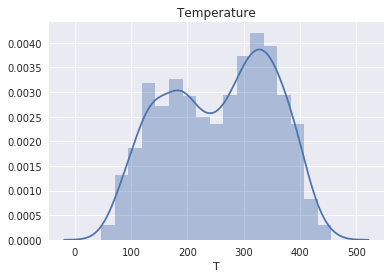

In [5]:
sns.distplot(train['T']);
plt.title("Temperature");
plt.show();

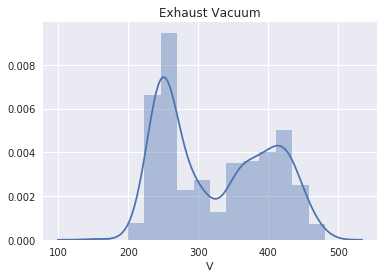

In [6]:
sns.distplot(train['V']);
plt.title("Exhaust Vacuum");
plt.show();

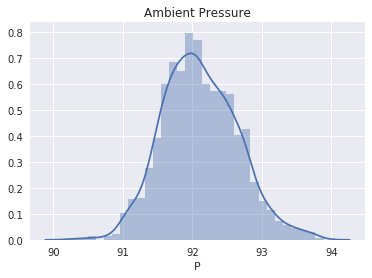

In [7]:
sns.distplot(train['P']);
plt.title("Ambient Pressure");
plt.show();

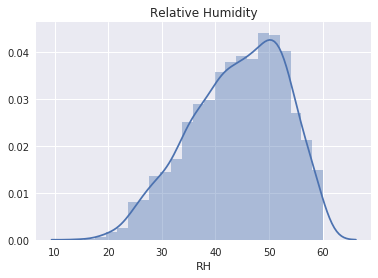

In [8]:
sns.distplot(train['RH']);
plt.title("Relative Humidity");
plt.show();

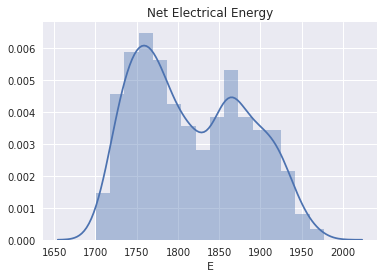

In [9]:
sns.distplot(train['E']);
plt.title("Net Electrical Energy");
plt.show();

## Relationship between each variable

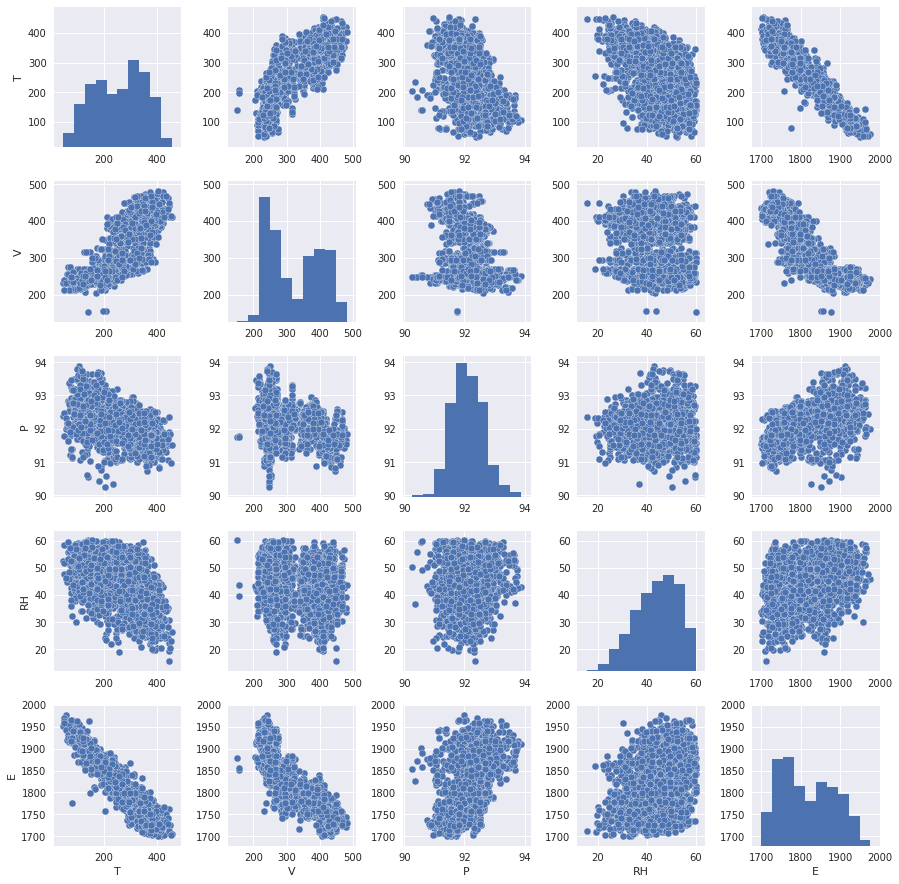

In [10]:
sns.pairplot(train)

## Correlation Matrix

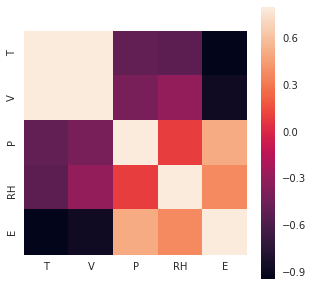

In [11]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corrmat, vmax=.8, square=True);

In [12]:
# select features for model training
feature_names = [x for x in train.columns if x not in ['E']]
target = train['E']

## Model Training and Validation

### 1. Without scaling

In [13]:
# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train[feature_names], target, test_size = 0.2, random_state = 42)

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [26]:
model1 = LassoCV(eps=1e-7)
## model training and prediction
model1.fit(X_train, y_train)
pred1 = model1.predict(X_test)

model2 = LinearRegression()
## model training and prediction
model2.fit(X_train, y_train)
pred2 = model2.predict(X_test)

model3 = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
## model training and prediction
model3.fit(X_train, y_train)
pred3 = model3.predict(X_test)

model4 = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.5, n_estimators=7200,
                             reg_alpha=0.9, reg_lambda=0.6,
                             subsample=0.2,seed=42, silent=1)
## model training and prediction
model4.fit(X_train, y_train)
pred4 = model4.predict(X_test)

pred = (pred1+pred2+pred3+pred4)/4
# model performance
print("Ensemble model:\n")
print("r2_score: " + str(r2_score(pred, y_test.values)))

Ensemble model:

r2_score: 0.9496843911056885


In [ ]:
model1 = LassoCV(eps=1e-7)
## model training and prediction
model1.fit(train[feature_names], target)
pred1 = model1.predict(test[feature_names])

model2 = LinearRegression()
## model training and prediction
model2.fit(train[feature_names], target)
pred2 = model2.predict(test[feature_names])

model3 = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
## model training and prediction
model3.fit(train[feature_names], target)
pred3 = model3.predict(test[feature_names])

model4 = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.5, n_estimators=7200,
                             reg_alpha=0.9, reg_lambda=0.6,
                             subsample=0.2,seed=42, silent=1)
## model training and prediction
model4.fit(train[feature_names], target)
pred4 = model4.predict(test[feature_names])

pred = (pred1+pred2+pred3+pred4)/4

In [ ]:
## make submission
sub = pd.DataFrame()
sub[''] = pred.astype(int)
sub.to_csv('result.csv', index=False,header=False)

In [ ]:
sub.head()

### 2. With scaling

In [27]:
scaled_train = train.copy()
scaled_test = test.copy()

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_train[feature_names] = scaler.fit_transform(scaled_train[feature_names])
scaled_test[feature_names] = scaler.fit_transform(scaled_test[feature_names])

scaled_train = pd.DataFrame(scaled_train, columns=['T', 'V', 'P','RH'])
scaled_test = pd.DataFrame(scaled_test, columns=['T', 'V', 'P','RH'])

In [28]:
train.head()

,T,V,P,RH,E
0,273.39,420.12,91.84,57.41,1778.12
1,195.26,248.88,92.29,35.21,1824.16
2,377.52,360.42,92.31,27.69,1761.72
3,171.60,244.98,91.61,56.99,1889.64
4,222.56,353.70,92.43,54.25,1806.68


In [29]:
# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_train[feature_names], target, test_size = 0.2, random_state = 42)

In [30]:
model1 = LassoCV(eps=1e-7)
## model training and prediction
model1.fit(X_train, y_train)
pred1 = model1.predict(X_test)

model2 = LinearRegression()
## model training and prediction
model2.fit(X_train, y_train)
pred2 = model2.predict(X_test)

model3 = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
## model training and prediction
model3.fit(X_train, y_train)
pred3 = model3.predict(X_test)

model4 = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.5, n_estimators=7200,
                             reg_alpha=0.9, reg_lambda=0.6,
                             subsample=0.2,seed=42, silent=1)
## model training and prediction
model4.fit(X_train, y_train)
pred4 = model4.predict(X_test)

pred = (pred1+pred2+pred3+pred4)/4
# model performance
print("Ensemble model:\n")
print("r2_score: " + str(r2_score(pred, y_test.values)))

Ensemble model:

r2_score: 0.9493495572886937
